# Graphs Convolutional Networks (GCNs)

In [1]:
from flax import nnx
import jax.numpy as jnp
import numpy as np
import scipy.sparse as sp  # Useful for handling sparse adjacency matrices
from typing import Sequence
import optax
import matplotlib.pyplot as plt
import torch_geometric

/Users/igorlimarochaazevedo/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data (Preprocessing)

In [2]:
def print_file_head(filename, num_lines=5):
    print(f"\n--- Head of {filename} {num_lines} lines ---")
    try:
        with open(filename, 'r') as f:
            for i, line in enumerate(f):
                if i >= num_lines:
                    break
                print(line.strip())
    except FileNotFoundError:
        print(f"Error: {filename} not found")


print_file_head("./dataset/cora/cora.cites", 5)
print_file_head("./dataset/cora/cora.content", 1)


--- Head of ./dataset/cora/cora.cites 5 lines ---
35	1033
35	103482
35	103515
35	1050679
35	1103960

--- Head of ./dataset/cora/cora.content 1 lines ---
31336	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

## Preprocessing

In [3]:
def _load_content_file(filepath: str):
    """Loads features and labels from the .content file."""
    print(f"Loading content file: {filepath}")
    idx_features_labels = np.genfromtxt(
        filepath,
        dtype=np.dtype(str)
    )
    features = sp.csr_matrix(
        idx_features_labels[:, 1:-1],
        dtype=np.float32
    )
    labels = idx_features_labels[:, -1]
    paper_ids = np.array(
        idx_features_labels[:, 0],
        dtype=np.int32
    )
    return features, labels, paper_ids

In [4]:
file_path = "./dataset/cora/cora.content"
features, labels, paper_ids = _load_content_file(file_path)

Loading content file: ./dataset/cora/cora.content


In [5]:
print("--- Features Matrix ---\n")
print(features.shape)
print(features[0].shape)
print(features[0])

--- Features Matrix ---

(2708, 1433)
(1, 1433)
<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1433 stored elements and shape (1, 1433)>
  Coords	Values
  (0, 0)	0.0
  (0, 1)	0.0
  (0, 2)	0.0
  (0, 3)	0.0
  (0, 4)	0.0
  (0, 5)	0.0
  (0, 6)	0.0
  (0, 7)	0.0
  (0, 8)	0.0
  (0, 9)	0.0
  (0, 10)	0.0
  (0, 11)	0.0
  (0, 12)	0.0
  (0, 13)	0.0
  (0, 14)	0.0
  (0, 15)	0.0
  (0, 16)	0.0
  (0, 17)	0.0
  (0, 18)	0.0
  (0, 19)	0.0
  (0, 20)	0.0
  (0, 21)	0.0
  (0, 22)	0.0
  (0, 23)	0.0
  (0, 24)	0.0
  :	:
  (0, 1408)	0.0
  (0, 1409)	0.0
  (0, 1410)	0.0
  (0, 1411)	0.0
  (0, 1412)	0.0
  (0, 1413)	0.0
  (0, 1414)	0.0
  (0, 1415)	0.0
  (0, 1416)	0.0
  (0, 1417)	0.0
  (0, 1418)	0.0
  (0, 1419)	0.0
  (0, 1420)	0.0
  (0, 1421)	0.0
  (0, 1422)	0.0
  (0, 1423)	0.0
  (0, 1424)	0.0
  (0, 1425)	0.0
  (0, 1426)	1.0
  (0, 1427)	0.0
  (0, 1428)	0.0
  (0, 1429)	0.0
  (0, 1430)	0.0
  (0, 1431)	0.0
  (0, 1432)	0.0


In [6]:
print("--- Labels Matrix ---\n")
print(labels.shape)
print(labels)

--- Labels Matrix ---

(2708,)
['Neural_Networks' 'Rule_Learning' 'Reinforcement_Learning' ...
 'Genetic_Algorithms' 'Case_Based' 'Neural_Networks']


In [7]:
print("--- Paper IDs ---\n")
print(paper_ids.shape)
print(paper_ids)

--- Paper IDs ---

(2708,)
[  31336 1061127 1106406 ... 1128978  117328   24043]


In [8]:
def _load_cites_file(filepath: str, idx_map: dict):
    """Loads citation links and builds the adjacency matrix."""
    print(f"Loading cites file: {filepath}")
    edges_unordered = np.genfromtxt(
        filepath,
        dtype=np.int32
    )

    # Convert paper IDs in edges to our new integer indices
    edges = np.array(
        list(map(
            idx_map.get,
            edges_unordered.flatten())
        ), dtype=np.int32,
    ).reshape(edges_unordered.shape)

    # Create COO (Coordinate) format sparse adjacency matrix
    adj = sp.coo_matrix(
        (
            np.ones(edges.shape[0]),
            (edges[:, 0], edges[:, 1])
        ),
        # Use len(idx_map) for the number of nodes
        shape=(len(idx_map), len(idx_map)),
        dtype=np.float32
    )

    # Build symmetric adjacency matrix
    adj = (
            adj +
            adj.T.multiply(adj.T > adj) -
            adj.multiply(adj.T > adj)
    )
    return adj

In [9]:
file_path = "./dataset/cora/cora.cites"
idx_map = {
    paper_id: idx for idx, paper_id in enumerate(paper_ids)
}
adj = _load_cites_file(file_path, idx_map)
print("-- Adjacency Matrix ---")
print(adj.shape)
print(adj[:2].shape)
print(adj[:2])

Loading cites file: ./dataset/cora/cora.cites
-- Adjacency Matrix ---
(2708, 2708)
(2, 2708)
<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 6 stored elements and shape (2, 2708)>
  Coords	Values
  (0, 8)	1.0
  (0, 14)	1.0
  (0, 258)	1.0
  (0, 435)	1.0
  (0, 544)	1.0
  (1, 344)	1.0


In [10]:
def _normalize_features(features: np.ndarray):
    """Normalizes node features."""
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    return features

In [11]:
def _one_hot_encode_labels(labels: np.ndarray):
    """Converts categorical labels to one-hot encoded format."""
    classes = sorted(list(set(labels)))
    class_to_idx = {
        c: i for i, c in enumerate(classes)
    }

    # Corrected labels_one_hot initialization shape
    labels_one_hot = np.zeros(
        (len(labels), len(classes)),
        dtype=np.float32
    )
    for i, label in enumerate(labels):
        labels_one_hot[i, class_to_idx[label]] = 1
    return labels_one_hot

In [12]:
def _create_masks(num_nodes: int):
    """Defines standard train, validation, and test masks."""
    idx_train = jnp.arange(140)
    idx_val = jnp.arange(140, 140 + 500)
    idx_test = jnp.arange(140 + 500, 140 + 500 + 1000)

    train_mask = jnp.zeros(
        num_nodes, dtype=bool
    ).at[idx_train].set(True)
    val_mask = jnp.zeros(
        num_nodes, dtype=bool
    ).at[idx_val].set(True)
    test_mask = jnp.zeros(
        num_nodes, dtype=bool
    ).at[idx_test].set(True)

    return train_mask, val_mask, test_mask

In [13]:
def load_cora(path: str = "./dataset/cora/"):
    """
    Loads and preprocesses the Cora dataset
    from raw .content and .cites files.

    Args:
        path (str): Directory path where
            cora.content and cora.cites are located.
            Defaults to "./dataset/cora/".

    Returns:
        tuple:
        (adj, features, labels, train_mask, val_mask, test_mask)
        where adj, features, and labels are JAX numpy arrays.
    """
    # 1. Load features and labels, and create paper ID to index mapping
    features_sparse, labels_raw, paper_ids = _load_content_file(path + "cora.content")
    idx_map = {paper_id: idx for idx, paper_id in enumerate(paper_ids)}

    # 2. Build adjacency matrix
    adj_sparse = _load_cites_file(path + "cora.cites", idx_map)

    # 3. Preprocess features
    features_normalized = _normalize_features(features_sparse)

    # 4. One-hot encode labels
    labels_one_hot = _one_hot_encode_labels(labels_raw)

    # 5. Create masks for data splits
    num_nodes = labels_raw.shape[0]  # Use the original number of labels for node count
    train_mask, val_mask, test_mask = _create_masks(num_nodes)

    # 6. Convert to JAX numpy arrays
    adj_jax = jnp.asarray(adj_sparse.todense(), dtype=jnp.float32)
    features_jax = jnp.asarray(features_normalized, dtype=jnp.float32)
    labels_jax = jnp.asarray(labels_one_hot, dtype=jnp.float32)

    return adj_jax, features_jax, labels_jax, train_mask, val_mask, test_mask

In [14]:
adj_raw, features, labels, train_mask, val_mask, test_mask = load_cora()

print(f"\nCora dataset loaded:")
print(f"Number of nodes: {adj_raw.shape[0]}")
print(f"Number of features per node: {features.shape[1]}")
print(f"Number of classes: {labels.shape[1]}")
print(f"Features shape: {features.shape}")
print(f"Adjacency matrix shape: {adj_raw.shape}")
print(f"Labels shape (one-hot encoded): {labels.shape}")
print(f"Train nodes: {jnp.sum(train_mask)}")
print(f"Validation nodes: {jnp.sum(val_mask)}")
print(f"Test nodes: {jnp.sum(test_mask)}")


Loading content file: ./dataset/cora/cora.content
Loading cites file: ./dataset/cora/cora.cites

Cora dataset loaded:
Number of nodes: 2708
Number of features per node: 1433
Number of classes: 7
Features shape: (2708, 1433)
Adjacency matrix shape: (2708, 2708)
Labels shape (one-hot encoded): (2708, 7)
Train nodes: 140
Validation nodes: 500
Test nodes: 1000


In [15]:
def preprocess_adjacency_matrix(adj):
    """
    Adds self-loops and symmetrically normalizes the adjacency matrix.

    Args:
        adj (jnp.ndarray): The raw adjacency matrix from your dataset.

    Returns:
        jnp.ndarray: The transformed adjacency matrix ready for the GCN.
    """
    # Input validation
    if adj is None:
        raise ValueError("Adjacency matrix cannot be None")
    if adj.ndim != 2:
        raise ValueError(f"Expected 2D adjacency matrix, got {adj.ndim}D")
    if adj.shape[0] != adj.shape[1]:
        raise ValueError(f"Adjacency matrix must be square, got shape {adj.shape}")

    # Step 1: Add self-loops (A' = A + I)
    # This ensures each node considers its own features during aggregation.
    adj_self_loops = adj + jnp.eye(adj.shape[0])

    # Step 2: Calculate the inverse square root of the degree matrix (D'^-0.5)
    # This creates the normalization factor.
    degrees = jnp.sum(adj_self_loops, axis=1)
    # Add small epsilon to prevent division by zero for isolated nodes
    D_hat = jnp.diag((degrees + 1e-8) ** -0.5)

    # Step 3: Symmetrically normalize the matrix (D'^-0.5 * A' * D'^-0.5)
    # This averages neighbor features, preventing issues from node degrees.
    A_hat = D_hat @ adj_self_loops @ D_hat

    return A_hat


In [16]:
# Create the correctly processed adjacency matrix
adj_normalized = preprocess_adjacency_matrix(adj_raw)

# Cora Dataset (Torch Geometric)

In [39]:
print(cora_dataset[0])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [17]:
# --- Load Data (Torch Geometric) ---
cora_dataset = torch_geometric.datasets.Planetoid(root="./dataset", name="Cora")

# Convert PyTorch tensors to JAX arrays
data = cora_dataset[0]
edge_index = jnp.array(data.edge_index.numpy())
features = jnp.array(data.x.numpy())
labels_int = jnp.array(data.y.numpy())
train_mask = jnp.array(data.train_mask.numpy())
val_mask = jnp.array(data.val_mask.numpy())
test_mask = jnp.array(data.test_mask.numpy())

# Convert edge_index to adjacency matrix
num_nodes = features.shape[0]
adj_raw = jnp.zeros((num_nodes, num_nodes))
adj_raw = adj_raw.at[edge_index[0], edge_index[1]].set(1.0)
adj_raw = adj_raw.at[edge_index[1], edge_index[0]].set(1.0)

# Convert integer labels to one-hot
num_classes = jnp.max(labels_int) + 1
labels = jnp.eye(num_classes)[labels_int]

# Process adjacency matrix (add self-loops and normalize)
adj_normalized = preprocess_adjacency_matrix(adj_raw)

In [18]:
print(f"\nCora dataset loaded:")
print(f"Number of nodes: {adj_normalized.shape[0]}")
print(f"Number of features per node: {features.shape[1]}")
print(f"Number of classes: {labels.shape[1]}")
print(f"Features shape: {features.shape}")
print(f"Adjacency matrix shape: {adj_normalized.shape}")
print(f"Labels shape (one-hot encoded): {labels.shape}")
print(f"Train nodes: {jnp.sum(train_mask)}")
print(f"Validation nodes: {jnp.sum(val_mask)}")
print(f"Test nodes: {jnp.sum(test_mask)}")


Cora dataset loaded:
Number of nodes: 2708
Number of features per node: 1433
Number of classes: 7
Features shape: (2708, 1433)
Adjacency matrix shape: (2708, 2708)
Labels shape (one-hot encoded): (2708, 7)
Train nodes: 140
Validation nodes: 500
Test nodes: 1000


# Building the MLP Layer (Benchmark)

In [19]:
class MLP(nnx.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout_rate=0.1, *, rngs: nnx.Rngs):
        self.layers = []
        current_features = in_features

        # Add hidden layers with Linear + ReLU + Dropout
        for hidden_dim in hidden_features:
            self.layers.extend([
                nnx.Linear(current_features, hidden_dim, rngs=rngs),
                nnx.relu,
                nnx.Dropout(rate=dropout_rate, rngs=rngs)
            ])
            current_features = hidden_dim

        # Final output layer (no activation, no dropout)
        self.layers.append(nnx.Linear(current_features, out_features, rngs=rngs))

    def __call__(self, x, *, rngs: nnx.Rngs):
        for layer in self.layers:
            if callable(layer):
                if hasattr(layer, '__call__') and 'rngs' in layer.__call__.__code__.co_varnames:
                    # For layers that need rngs (Linear, Dropout)
                    x = layer(x, rngs=rngs)
                else:
                    # For activation functions (relu)
                    x = layer(x)
        return x

# Building the GCN Layer

In [20]:
class GCNLayer(nnx.Module):
    def __init__(
            self,
            input_features: int,
            output_features: int,
            dropout_rate: float = 0.0,
            apply_activation: bool = True,
            *, rngs: nnx.Rngs
    ):
        self.linear = nnx.Linear(
            input_features,
            output_features,
            kernel_init=nnx.initializers.glorot_uniform(),
            rngs=rngs
        )
        self.dropout = nnx.Dropout(
            rate=dropout_rate,
            rngs=rngs
        )
        self.apply_activation = apply_activation

    def __call__(
            self,
            A_hat: jnp.ndarray,
            H: jnp.ndarray,
            *, rngs: nnx.Rngs,
    ):
        """
        Applies a single Graph Convolutional
        Network layer using NNX.

        Args:
            A_hat (jnp.ndarray): The symmetrically
                normalized adjacency matrix.
            H (jnp.ndarray): The input node embeddings/
                features from the previous layer.
            rngs (nnx.Rngs): Random number generator
                collection for dropout.

        Returns:
            jnp.ndarray: The output node embeddings/
                features for the current layer.
        """
        # 1. Dropout for regularization
        # nnx knows when to apply dropout - train
        #   and when don't - eval
        H_dropped = self.dropout(H, rngs=rngs)

        # 2. Linear Transformation (H^(l) * W^(l))
        H_linear = self.linear(H_dropped)

        # 3. Graph Convolution (A_hat * H_linear)
        H_aggregated = A_hat @ H_linear

        # 4. Activation Function (if enabled)
        if self.apply_activation:
            H_output = nnx.relu(H_aggregated)
        else:
            H_output = H_aggregated

        return H_output


In [21]:
class GCN(nnx.Module):
    """A graph Convolutional Network Model"""

    def __init__(
            self,
            input_features: int,
            hidden_features: Sequence[int],
            output_features: int,
            dropout_rate: float,
            *, rngs: nnx.Rngs
    ):
        self.gcn_layers = []
        current_features = input_features

        # Create the hidden GCN layers
        for hidden_dim in hidden_features:
            self.gcn_layers.append(
                GCNLayer(
                    input_features=current_features,
                    output_features=hidden_dim,
                    dropout_rate=dropout_rate,
                    rngs=rngs
                )
            )
            # The input of the next layer is the
            #   output to this one
            current_features = hidden_dim

        # The final layer maps node embeddings to output classes
        # No activation for final layer (raw logits for classification)
        self.output_layer = GCNLayer(
            input_features=current_features,
            output_features=output_features,
            dropout_rate=0.0,  # No dropout in final layer
            apply_activation=False,
            rngs=rngs
        )

    def __call__(
            self,
            A_hat: jnp.ndarray,
            H: jnp.ndarray,
            *, rngs: nnx.Rngs,
    ):
        """Performs the forward pass of the GCN."""
        # Pass data through all the GCN layers
        for layer in self.gcn_layers:
            H = layer(A_hat=A_hat, H=H, rngs=rngs)

        # Apply the final layer to get logits
        logits = self.output_layer(A_hat=A_hat, H=H, rngs=rngs)
        return logits

# Loss Function

In [36]:
# --- Loss & Accuracy Functions ---
def categorical_loss(logits, labels, mask):
    """Calculates masked cross-entropy loss."""
    # Convert one-hot labels to integer labels for this loss function
    int_labels = jnp.argmax(labels, axis=1)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, int_labels)
    # Use jnp.where to apply mask without boolean indexing
    masked_loss = jnp.where(mask, loss, 0.0)
    # Return the mean loss only for the nodes in the mask
    return jnp.sum(masked_loss) / jnp.sum(mask)

def loss_fn(model, batch, rngs: nnx.Rngs):
    """Generic loss function that works with both GCN and MLP models."""
    # Check if model is GCN (needs adjacency matrix) or MLP (only features)
    if hasattr(model, 'gcn_layers') or isinstance(model, GCN):
        # GCN model - pass adjacency matrix
        logits = model(
            batch["adj"],
            batch["features"],
            rngs=rngs
        )
    else:
        # MLP model - only pass features
        logits = model(batch["features"], rngs=rngs)

    loss = categorical_loss(
        logits,
        batch["label"],
        batch["mask"]
    )
    return loss, logits

# Train Step

In [23]:
@nnx.jit
def train_step(
        model,
        optimizer,
        metrics: nnx.MultiMetric,
        batch,
        rngs: nnx.Rngs
):
    """Performs one training step: computes grads, updates model."""
    grad_fn = nnx.value_and_grad(
        loss_fn,
        has_aux=True,
    )
    (loss, logits), grads = grad_fn(model, batch, rngs)

    metrics.update(
        loss=loss,
        logits=logits,
        labels=jnp.argmax(batch["label"], axis=1),
        mask=batch["mask"],
    )
    optimizer.update(grads)  # In-place updates

# Eval Step

In [24]:
@nnx.jit
def eval_step(
        model,
        metrics: nnx.MultiMetric,
        batch,
        rngs: nnx.Rngs
):
    # In evaluation mode, dropout is automatically disabled by NNX
    # when no training is happening (deterministic behavior)
    loss, logits = loss_fn(model, batch, rngs)

    metrics.update(
        loss=loss,
        logits=logits,
        labels=jnp.argmax(batch["label"], axis=1),
        mask=batch["mask"],
    )

# Batch and Iterators

In [25]:
# Create batch format for GCN training
def create_batch(adj, features, labels, mask):
    """Creates a batch in the format expected by the training loop."""
    return {
        "adj": adj,
        "label": labels,
        "mask": mask,
        "features": features
    }


# For the training loop, you can also create a simple dataset iterator
def create_dataset_iterator(batch, num_repeats=1):
    """Creates an iterator that yields the same batch repeatedly."""
    for _ in range(num_repeats):
        yield batch

# Custom Metrics

In [26]:
class MaskedAccuracy(nnx.metrics.Average):
    """Accuracy metric that respects node masks for graph node classification."""

    def __init__(self):
        super().__init__()

    def update(self, *, logits, labels, mask=None, **kwargs):
        predictions = jnp.argmax(logits, axis=-1)
        correct_predictions = (predictions == labels).astype(jnp.float32)

        if mask is not None:
            # Only count predictions for masked nodes
            masked_correct = jnp.where(mask, correct_predictions, 0.0)
            masked_total = jnp.where(mask, 1.0, 0.0)
            # Update with the average accuracy for this batch
            batch_accuracy = jnp.sum(masked_correct) / (jnp.sum(masked_total) + 1e-8)
        else:
            batch_accuracy = jnp.mean(correct_predictions)

        super().update(values=batch_accuracy)

class F1Score(nnx.metrics.Average):
    """Macro-averaged F1 score for multi-class classification."""

    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def update(self, *, logits, labels, **kwargs):
        predictions = jnp.argmax(logits, axis=-1)

        # Calculate F1 per class
        f1_scores = []
        for class_idx in range(self.num_classes):
            pred_class = (predictions == class_idx)
            true_class = (labels == class_idx)

            tp = jnp.sum(pred_class & true_class)
            fp = jnp.sum(pred_class & ~true_class)
            fn = jnp.sum(~pred_class & true_class)

            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
            f1_scores.append(f1)

        # Compute macro-averaged F1
        macro_f1 = jnp.mean(jnp.array(f1_scores))
        super().update(values=macro_f1)

# Train Model

In [27]:
def train_model(model, train_batch, val_batch, test_batch,
                learning_rate=0.01, epochs=200, eval_every=20,
                model_name="Model"):
    """
    Generic training function that works with both GCN and MLP models.

    Args:
        model: The model to train (GCN or MLP)
        train_batch: Training data batch
        val_batch: Validation data batch
        test_batch: Test data batch
        learning_rate: Learning rate for optimizer
        epochs: Number of training epochs
        eval_every: Evaluate every N steps
        model_name: Name for logging purposes

    Returns:
        dict: Training history and final results
    """
    # Initialize optimizer
    optimizer = nnx.Optimizer(model, optax.adam(learning_rate))

    # Initialize metrics
    num_classes = train_batch['label'].shape[1]
    metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        masked_accuracy=MaskedAccuracy(),
        f1_score=F1Score(num_classes=num_classes),
        loss=nnx.metrics.Average('loss'),
    )

    # Training history
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_masked_accuracy': [],
        'train_f1_score': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_masked_accuracy': [],
        'val_f1_score': [],
    }

    # Best model tracking
    best_val_acc = 0.0
    best_model_state = None

    # Initialize RNG
    rng = nnx.Rngs(42)

    print(f"\n=== Training {model_name} ===\n")

    # Training loop
    for step in range(epochs):
        # Training step
        train_step(model, optimizer, metrics, train_batch, rng)

        # Evaluation
        if step > 0 and (step % eval_every == 0 or step == epochs - 1):
            # Compute training metrics
            for metric, value in metrics.compute().items():
                metrics_history[f'train_{metric}'].append(value)
            metrics.reset()

            # Compute validation metrics
            eval_step(model, metrics, val_batch, rng)
            for metric, value in metrics.compute().items():
                metrics_history[f'val_{metric}'].append(value)
            metrics.reset()

            # Track best model
            current_val_acc = metrics_history['val_accuracy'][-1]
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                best_model_state = nnx.state(model)
                print(f"New best validation accuracy: {best_val_acc:.4f}")

            # Log progress
            print(f"Step {step}: Train Loss: {metrics_history['train_loss'][-1]:.4f}, "
                  f"Train Acc: {metrics_history['train_accuracy'][-1]:.4f}, "
                  f"Train Masked Acc: {metrics_history['train_masked_accuracy'][-1]:.4f}")
            print(f"          Val Loss: {metrics_history['val_loss'][-1]:.4f}, "
                  f"Val Acc: {metrics_history['val_accuracy'][-1]:.4f}, "
                  f"Val Masked Acc: {metrics_history['val_masked_accuracy'][-1]:.4f}")

    # Final test evaluation with best model
    if best_model_state is not None:
        nnx.update(model, best_model_state)

    test_metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        masked_accuracy=MaskedAccuracy(),
        f1_score=F1Score(num_classes=num_classes),
        loss=nnx.metrics.Average('loss'),
    )

    eval_step(model, test_metrics, test_batch, rng)
    final_test_results = test_metrics.compute()

    print(f"\n=== {model_name} Final Results ===\n")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Test Accuracy: {final_test_results['accuracy']:.4f}")
    print(f"Final Test Masked Accuracy: {final_test_results['masked_accuracy']:.4f}")
    print(f"Final Test F1 Score: {final_test_results['f1_score']:.4f}")

    return {
        'metrics_history': metrics_history,
        'final_test_results': final_test_results,
        'best_val_acc': best_val_acc,
        'model_state': best_model_state
    }

# Training the GCN Model

In [31]:
# --- Model & Hyperparameters ---
LEARNING_RATE = 0.01
EPOCHS = 200
HIDDEN_FEATURES = [16, 16]
DROPOUT_RATE = 0.2

In [28]:
# Create train, validation, and test batches
train_batch = create_batch(adj_normalized, features, labels, train_mask)
val_batch = create_batch(adj_normalized, features, labels, val_mask)
test_batch = create_batch(adj_normalized, features, labels, test_mask)

In [29]:
# Print dataset information
print(f"\nDataset splits:")
print(f"Training nodes: {jnp.sum(train_mask)}")
print(f"Validation nodes: {jnp.sum(val_mask)}")
print(f"Test nodes: {jnp.sum(test_mask)}")
print(f"Total nodes: {len(features)}")


Dataset splits:
Training nodes: 140
Validation nodes: 500
Test nodes: 1000
Total nodes: 2708


In [32]:
# Create dataset iterators
train_ds = create_dataset_iterator(train_batch, EPOCHS)
val_ds = create_dataset_iterator(val_batch, 1)  # For evaluation
test_ds = create_dataset_iterator(test_batch, 1)  # For final evaluation

print("Batch format created successfully!")
print(f"Train batch keys: {list(train_batch.keys())}")
print(f"Features shape: {train_batch['features'].shape}")
print(f"Labels shape: {train_batch['label'].shape}")
print(f"Adjacency shape: {train_batch['adj'].shape}")
print(f"Train mask sum: {jnp.sum(train_batch['mask'])}")
print(f"Validation mask sum: {jnp.sum(val_batch['mask'])}")
print(f"Test mask sum: {jnp.sum(test_batch['mask'])}")

Batch format created successfully!
Train batch keys: ['adj', 'label', 'mask', 'features']
Features shape: (2708, 1433)
Labels shape: (2708, 7)
Adjacency shape: (2708, 2708)
Train mask sum: 140
Validation mask sum: 500
Test mask sum: 1000


In [33]:
# --- Model Comparison: GCN vs MLP ---

# Initialize both models
gcn_model = GCN(
    input_features=features.shape[1],
    output_features=labels.shape[1],
    hidden_features=HIDDEN_FEATURES,
    dropout_rate=DROPOUT_RATE,
    rngs=nnx.Rngs(0),
)

mlp_model = MLP(
    in_features=features.shape[1],
    hidden_features=HIDDEN_FEATURES,
    out_features=labels.shape[1],
    dropout_rate=DROPOUT_RATE,
    rngs=nnx.Rngs(1),
)

In [34]:
# Visualize GCN model
graphdef, state = nnx.split(gcn_model)
nnx.display(graphdef, state)

In [37]:
# Train both models
print("=" * 60)
print("COMPARING GCN vs MLP PERFORMANCE")
print("=" * 60)

# Train GCN
gcn_results = train_model(
    model=gcn_model,
    train_batch=train_batch,
    val_batch=val_batch,
    test_batch=test_batch,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    eval_every=20,
    model_name="GCN"
)

# Train MLP
mlp_results = train_model(
    model=mlp_model,
    train_batch=train_batch,
    val_batch=val_batch,
    test_batch=test_batch,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    eval_every=20,
    model_name="MLP"
)

COMPARING GCN vs MLP PERFORMANCE

=== Training GCN ===

New best validation accuracy: 0.7884
Step 20: Train Loss: 0.9834, Train Acc: 0.5537, Train Masked Acc: 0.7327
          Val Loss: 0.8840, Val Acc: 0.7884, Val Masked Acc: 0.7580
Step 40: Train Loss: 0.0415, Train Acc: 0.7741, Train Masked Acc: 0.9939
          Val Loss: 1.1664, Val Acc: 0.7714, Val Masked Acc: 0.7480
Step 60: Train Loss: 0.0080, Train Acc: 0.7652, Train Masked Acc: 0.9979
          Val Loss: 1.5372, Val Acc: 0.7685, Val Masked Acc: 0.7340
Step 80: Train Loss: 0.0036, Train Acc: 0.7678, Train Masked Acc: 0.9993
          Val Loss: 1.4651, Val Acc: 0.7736, Val Masked Acc: 0.7680
Step 100: Train Loss: 0.0016, Train Acc: 0.7692, Train Masked Acc: 1.0000
          Val Loss: 1.5625, Val Acc: 0.7688, Val Masked Acc: 0.7480
Step 120: Train Loss: 0.0013, Train Acc: 0.7615, Train Masked Acc: 1.0000
          Val Loss: 1.5265, Val Acc: 0.7762, Val Masked Acc: 0.7460
Step 140: Train Loss: 0.0011, Train Acc: 0.7662, Train Mask


FINAL PERFORMANCE COMPARISON
Metric                    GCN             MLP             Difference     
----------------------------------------------------------------------
Test Accuracy             0.7888          0.4786          +0.3102        
Test Masked Accuracy      0.7810          0.4450          +0.3360        
Test F1 Score             0.7794          0.4725          +0.3068        
Test Loss                 0.7469          3.1705          -2.4236        
Best Val Accuracy         0.7884          0.4856          +0.3028        


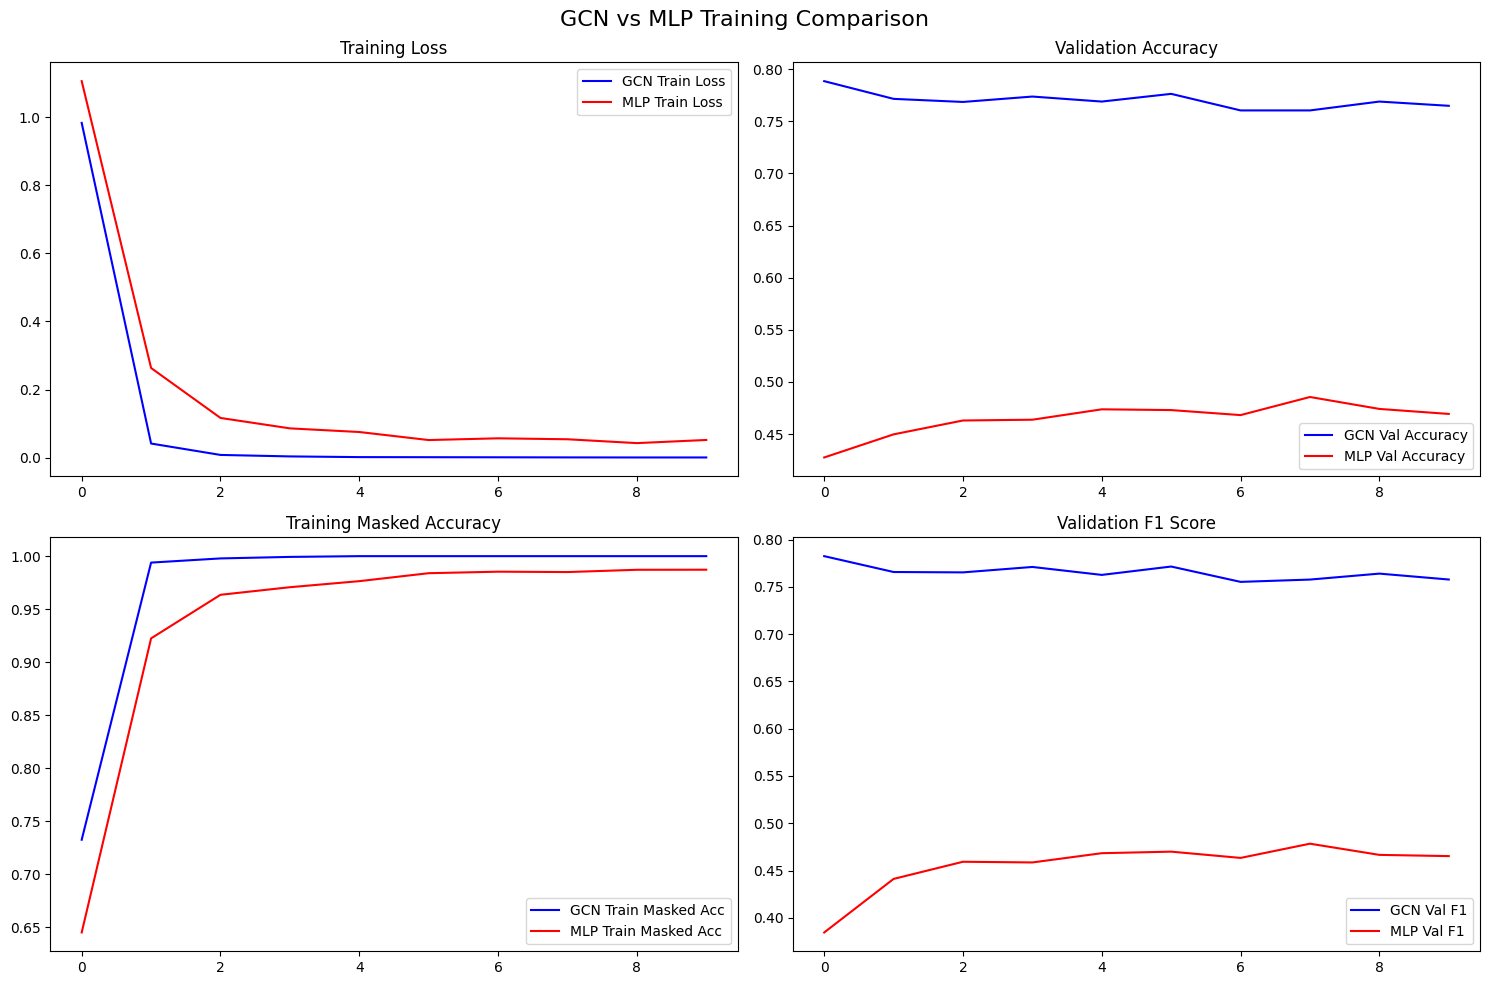


SUMMARY
Winner: GCN
Test Accuracy Improvement: 0.3102 (31.02%)
GCN leverages graph structure: ✓


In [38]:
# Performance comparison
print("\n" + "=" * 60)
print("FINAL PERFORMANCE COMPARISON")
print("=" * 60)


def print_comparison_table():
    print(f"{'Metric':<25} {'GCN':<15} {'MLP':<15} {'Difference':<15}")
    print("-" * 70)

    metrics_to_compare = [
        ('Test Accuracy', 'accuracy'),
        ('Test Masked Accuracy', 'masked_accuracy'),
        ('Test F1 Score', 'f1_score'),
        ('Test Loss', 'loss'),
        ('Best Val Accuracy', 'best_val_acc')
    ]

    for display_name, metric_key in metrics_to_compare:
        if metric_key == 'best_val_acc':
            gcn_val = gcn_results[metric_key]
            mlp_val = mlp_results[metric_key]
        else:
            gcn_val = gcn_results['final_test_results'][metric_key]
            mlp_val = mlp_results['final_test_results'][metric_key]

        diff = gcn_val - mlp_val
        diff_str = f"+{diff:.4f}" if diff > 0 else f"{diff:.4f}"

        print(f"{display_name:<25} {gcn_val:<15.4f} {mlp_val:<15.4f} {diff_str:<15}")


print_comparison_table()

# Plot comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('GCN vs MLP Training Comparison', fontsize=16)

ax1.set_title('Training Loss')
ax2.set_title('Validation Accuracy')
ax3.set_title('Training Masked Accuracy')
ax4.set_title('Validation F1 Score')

# Plot training curves for both models
models_data = [
    ('GCN', gcn_results['metrics_history'], 'blue'),
    ('MLP', mlp_results['metrics_history'], 'red')
]

for model_name, history, color in models_data:
    ax1.plot(history['train_loss'], label=f'{model_name} Train Loss', color=color, linestyle='-')
    ax2.plot(history['val_accuracy'], label=f'{model_name} Val Accuracy', color=color, linestyle='-')
    ax3.plot(history['train_masked_accuracy'], label=f'{model_name} Train Masked Acc', color=color, linestyle='-')
    ax4.plot(history['val_f1_score'], label=f'{model_name} Val F1', color=color, linestyle='-')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

# Summary
print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
gcn_test_acc = gcn_results['final_test_results']['accuracy']
mlp_test_acc = mlp_results['final_test_results']['accuracy']

if gcn_test_acc > mlp_test_acc:
    winner = "GCN"
    improvement = gcn_test_acc - mlp_test_acc
else:
    winner = "MLP"
    improvement = mlp_test_acc - gcn_test_acc

print(f"Winner: {winner}")
print(f"Test Accuracy Improvement: {improvement:.4f} ({improvement * 100:.2f}%)")
print(f"GCN leverages graph structure: {'✓' if gcn_test_acc > mlp_test_acc else '✗'}")
print(f"{'=' * 60}")
